In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from keras.datasets import mnist
from tensorflow.keras import Model
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout, MaxPooling2D
from keras.datasets import mnist
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# any additional imports you may require


# **Loading Dataset**

You will be using MNIST handwritten digits to create a digit detection system. The dataset contain binary images of handwritten digits, and has has a training set of 60,000 examples, and a test set of 10,000 examples. The dataset can be loaded using the following commands:

> from keras.datasets import mnist

> (trainX, trainY), (testX, testY) = mnist.load_data()

Starter code has already been provided to you. In the load_dataset() function, perform the following tasks:


*   Normalize pixel values between 0 and 1
*   One hot encode true labels using the [to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.



In [ ]:
def load_dataset():
  (trainX, trainY), (testX, testY) = mnist.load_data()
  trainX= (trainX/255).astype('float32')
  testX= (testX/255).astype('float32')
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return trainX, trainY, testX, testY

In [ ]:
trainX, trainY, testX, testY = load_dataset()

# **Part 1**

In the first part, you will be creating a neural network from scratch.  Often the code ishidden behind libraries.  The purpose of this task is to give you hand-on experience withthe mathematical foundations of neural network architectures.  After implementing this task, you will know exactly how forward and backward pass functions are implemented mathematically and in code. 

In [ ]:
class NeuralNetwork():
  
  @staticmethod
  def cross_entropy_loss(y_pred, y_true):
    loss =  -(y_true * np.log(y_pred)).sum()
 
    return loss

  @staticmethod
  def softmax(Z):
    '''Used as the activation function in output layer'''
    expz = np.exp(Z)
    output = expz / expz.sum(axis=1, keepdims=True)
    
    return output


  @staticmethod
  def sigmoid(Z):
    '''Used as the activation function in every hidden layer'''
    output = 1 / (1 + np.exp(-Z))
    return output


  def __init__(self, list_of_nodes):
    '''Constructor of our neural network class'''
    
    if len(list_of_nodes) < 2:
        raise ValueError('Network must have atleast 2 layers (input and output).')
    if not (np.array(list_of_nodes) > 0).all():
        raise ValueError('Number of nodes in all layers must be positive.')
    
    self.total_layers = len(list_of_nodes) # total layers of your neural network
    self.list_of_nodes = list_of_nodes # list containing count of the number of nodes in every layer.
    self.input_shape = list_of_nodes[0] # number of nodes in input layer
    self.output_shape = list_of_nodes[-1] # number of nodes in output layer
    
    self.__init_weights_and_biases(list_of_nodes)

  def __init_weights_and_biases(self, list_of_nodes):
    '''Initialize all weights based on normal standard distribution and all biases to 0'''

    self.weights_ = []
    self.biases_ = []
    for i,_ in enumerate(list_of_nodes):
        if i == 0:
            #Input layer is skipped because it has no weights or biases
            continue
        
        Weights = np.random.normal(size=(list_of_nodes[i-1], list_of_nodes[i]))
        Biases = np.zeros(shape=(list_of_nodes[i],))
        
        self.weights_.append(Weights)
        self.biases_.append(Biases)

  def forward_pass(self, input_data):
    '''
    Traverse the neural network and calculate the output of every layer.
    The function should return a list containing outputs of every layer.
    '''
    layer_outputs = []
    input_ = input_data
    weights_size = len(self.weights_)
    for i in range(weights_size-1):
        input_ = self.sigmoid(input_.dot(self.weights_[i]) + self.biases_[i])
        layer_outputs.append(input_)
    input_ = self.softmax(input_.dot(self.weights_[weights_size-1]) + self.biases_[weights_size-1])
    layer_outputs.append(input_)
    return layer_outputs

  def backward_pass(self,y, layer_outputs):
    '''
    Traverse the neural network starting from the output layer. 
    and compute partial derivatives. 
    The function should return a list containing partial derivatives of every layer.
    '''
    derivatives = []
    weights_size = len(self.weights_)
    dl_2 = layer_outputs[weights_size-1] - y
    dv_2 = layer_outputs[weights_size-1]*(1-layer_outputs[weights_size-1])
    dl_w2 = np.multiply(dl_2, dv_2)
    derivatives = [dl_w2]
    for i in range(weights_size-1, 0, -1):
        dl_ = dl_w2.dot(np.transpose(self.weights_[i]))
        drv_ = layer_outputs[i-1]*(1-layer_outputs[i-1])
        dl_w = np.multiply(dl_, drv_)
        derivatives.insert(0, dl_w)
        dl_w2 = dl_w
   
    return derivatives

  def update(self, derivatives, layer_outputs,learning_rate):
    '''Update weights and biases'''

    last_layer_index = self.total_layers-1
    for i in range(last_layer_index-1, -1, -1):
      self.weights_[i] = self.weights_[i] - np.transpose(learning_rate*(np.transpose(derivatives[i]).dot(layer_outputs[i])))
      self.biases_[i] = self.biases_[i] - learning_rate*sum(derivatives[i])

  def fit(self, X_train, Y_train, epochs, learning_rate):
    ''' Call forward_pass(), backward_pass(), and the update() function'''

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    #dividing training data into training set and validation set
    X_train_set = X_train[6000:]
    Y_train_set = Y_train[6000:]
    X_valid_set = X_train[0:6000]
    Y_valid_set = Y_train[0:6000]

    for epoch in tqdm(range(epochs)):

      #Stochastic gradient descent
      num_samples = X_train_set.shape[0]
      for i in range(num_samples):
        
        x = X_train_set[i,:].reshape((1,self.input_shape)) # features of the ith sample
        y = Y_train_set[i,:].reshape((1,self.output_shape)) # true label of the ith sample
        
        layer_outputs = self.forward_pass(x)
        derivatives = self.backward_pass(y, layer_outputs)
        layer_inputs = [x] + layer_outputs[:-1]
        self.update(derivatives, layer_inputs, learning_rate)
     

    
      train_predict = self.predict(X_train_set)
      validation_predict = self.predict(X_valid_set)

      training_loss.append(self.cross_entropy_loss(train_predict, Y_train_set)) #appending training loss
      validation_loss.append(self.cross_entropy_loss(validation_predict, Y_valid_set)) #appending validation loss
      training_accuracy.append(accuracy_score(np.argmax(Y_train_set,axis=1),np.argmax(train_predict,axis=1))) # appending training accuracy
      validation_accuracy.append(accuracy_score(np.argmax(Y_valid_set,axis=1),np.argmax(validation_predict,axis=1))) # appending validation accuracy
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def evaluate(self,Y_true,Y_pred):
    con_matrix = pd.crosstab(Y_pred,Y_true)
    c = np.array(con_matrix)

    print('confusion matrix:\n',c)


    print('Accuracy:\n',1- (np.count_nonzero(Y_true - Y_pred))/len(Y_true))


    precision = []
    for i in range(len(c)):
        n = np.diag(c)[i]
        d =np.sum(c[i])
        prec = n/d
        precision.append(prec)


    recall = []
    for i in range(len(c)):
        nu = np.diag(c)[i]
        de =np.sum(c[:,i])
        rec = nu/de
        recall.append(rec)

    def f1(precision,recall):
        f1_score = (2 * precision * recall) / (precision + recall)
        return f1_score

    f1_ = []
    for i in range(len(c)):
      f1_.append(f1(precision[i],recall[i]))

    macro_F1 = sum(f1_) / len(f1_)

    print('Macro F1 score:\n',macro_F1)
    
   
    pass

  def predict(self, X):
    predicted_labels = []
    n = X.shape[0]
    for i in range(n):
        x = X[i,:].reshape((1,self.input_shape))
        y_pred = self.forward_pass(x)[-1]
        predicted_labels.append(y_pred.reshape((self.output_shape,)))
    return np.array(predicted_labels)

  def predict(self, X):
    predicted_labels = []
    n = X.shape[0]
    for i in range(n):
        x = X[i,:].reshape((1,self.input_shape))
        y_pred = self.forward_pass(x)[-1]
        predicted_labels.append(y_pred.reshape((self.output_shape,)))
    return np.array(predicted_labels)

Reshape the dataset to a 2D array using [NumPy reshape function](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

In [ ]:
trainX = trainX.reshape(60000, -1)
testX  = testX.reshape(10000, -1)


print('Train: X=%s, Y=%s' % (trainX.shape, trainY.shape)) #should print "Train: X=(60000, 784), y=(60000,10)"
print('Test: X=%s, Y=%s' % (testX.shape, testY.shape)) #should print "Test: X=(10000, 784), y=(10000,10)"

Train: X=(60000, 784), Y=(60000, 10)
Test: X=(10000, 784), Y=(10000, 10)


Initialize your class. The class can have arbitrary number of hidden layers and nodes depending on the parameters passed. For example, the class instance declared as:


> **nn = NeuralNetwork([784,20,20,10])**


contains an input layer with 784 nodes, 2 hidden layer with 20 nodes each and an output layer with 10 nodes.

In [ ]:
  nn = NeuralNetwork([784,20,20,10])

Call the fit function to train your model.

Plot graphs for different types of neural network architectures. Also experiment with different learning rates. No of epochs should be on the $x$-axis and training \& validation loss on the $y$-axis.

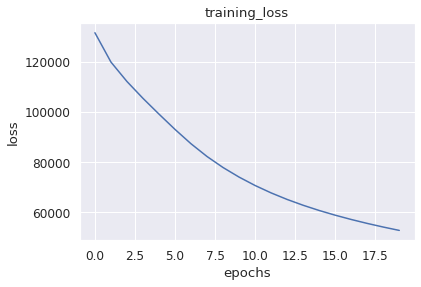

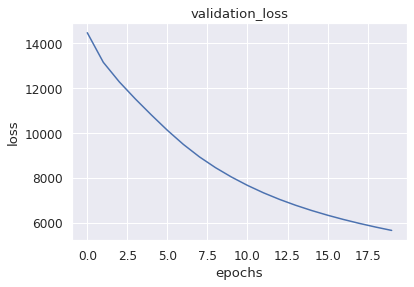

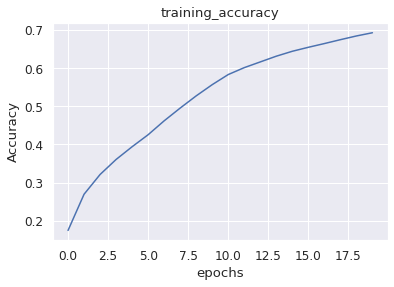

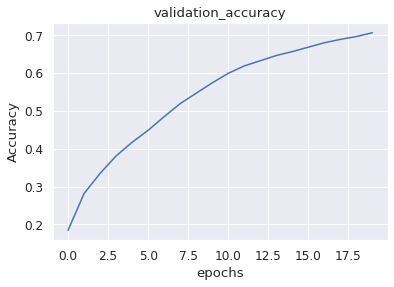

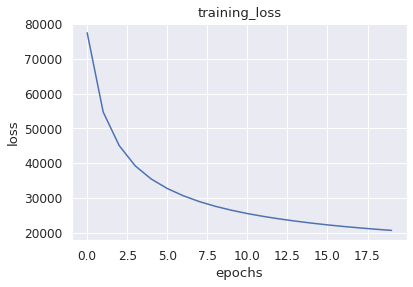

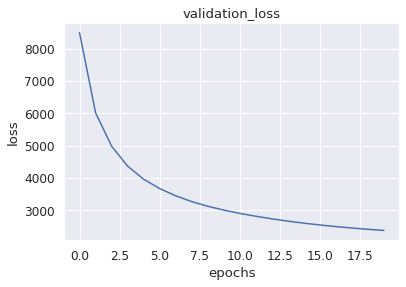

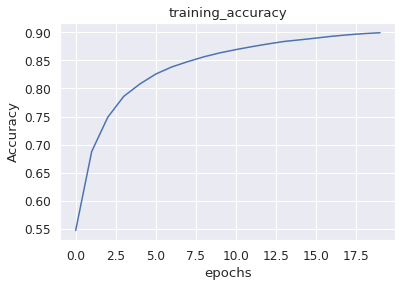

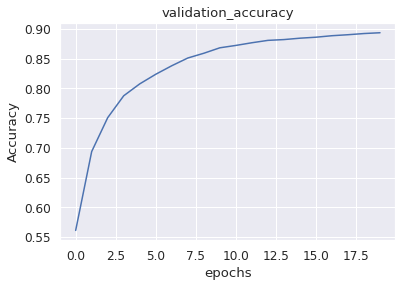

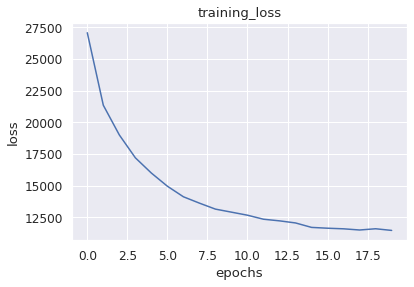

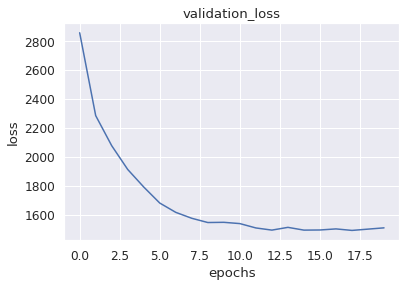

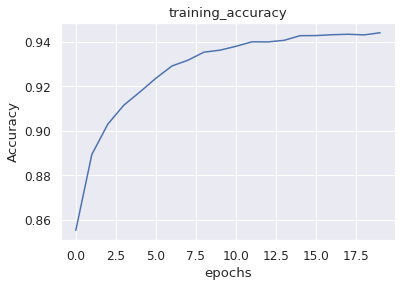

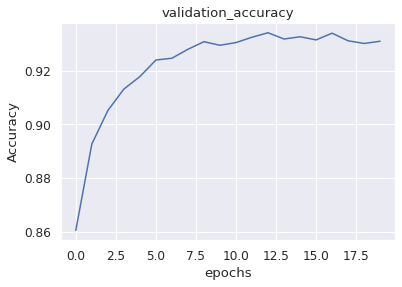

In [ ]:

learning_rate = [0.001,0.01, 0.1]
for lr in learning_rate:
  nn = NeuralNetwork([784,20,20,10])
  n = nn.fit(trainX, trainY, 20, lr)
  titles = ['training_loss', 'validation_loss', 'training_accuracy', 'validation_accuracy']
  for i,j in enumerate(titles):
    plt.plot(n[i])
    plt.title(lr)
    plt.xlabel('epochs')
    if i < 2:
      plt.ylabel('loss')
    else:
      plt.ylabel('Accuracy')
    plt.title(j)
    plt.show()

Predict the labels of test data using the *predict() function*. Skeleton code for this function is already given to you. You may find [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful to extract labels.

In [ ]:
y_predicted = nn.predict(testX)
yt_pred = []
for i in range(len(y_predicted)):
    lbl = np.zeros(10)
    ind = np.argmax(y_predicted[i])
    lbl[ind] = 1
    yt_pred.append(lbl)


Implement and call the evaluate function. Pass true labels and predicted labels of test data as parameters and report your results.

In [ ]:
y_true = np.argmax(testY, axis=1)
y_pred = np.argmax(yt_pred, axis=1)


nn.evaluate(y_pred, y_true)

confusion matrix:
 [[ 962    0    2    0    2    8    2    1    3    0]
 [   0 1110    3    2    0    0    3    2   15    0]
 [  14    8  935   22   11    7   10    8   16    1]
 [   9    4    8  916    1   31    0   17   21    3]
 [   2    2    6    0  894    6   12    2    4   54]
 [  16    2    4   20    4  819    8    3    9    7]
 [  26    4    9    3   13   18  879    0    6    0]
 [   1   13   20    6    6    6    0  943    1   32]
 [   8    6   10   15    7   27    6    4  882    9]
 [   7    7    1    4   20   13    2   13   13  929]]
Accuracy:
 0.9269000000000001
Macro F1 score:
 0.9260150147479871


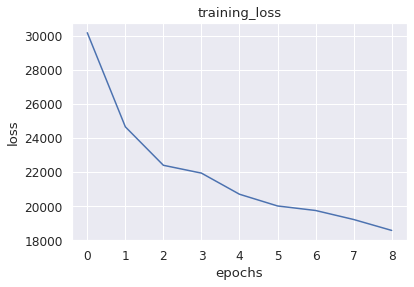

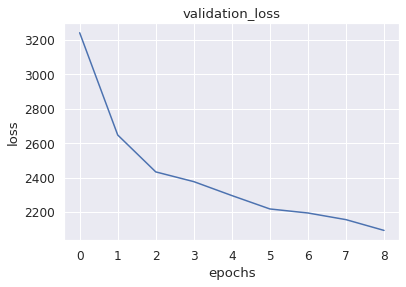

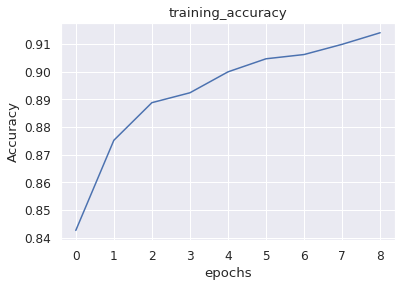

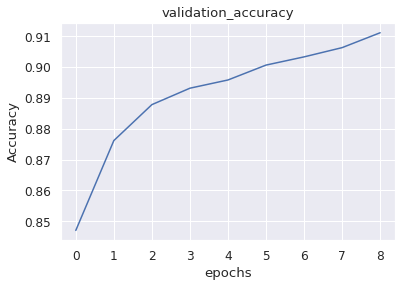

In [121]:
#one hidden layer with 10 nodes 
n1 = NeuralNetwork([784,10,10])
n = n1.fit(trainX, trainY, 9, 0.1)
titles = ['training_loss', 'validation_loss', 'training_accuracy', 'validation_accuracy']
for i,j in enumerate(titles):
  plt.plot(n[i])
  plt.title(lr)
  plt.xlabel('epochs')
  if i < 2:
    plt.ylabel('loss')
  else:
    plt.ylabel('Accuracy')
  plt.title(j)
  plt.show()

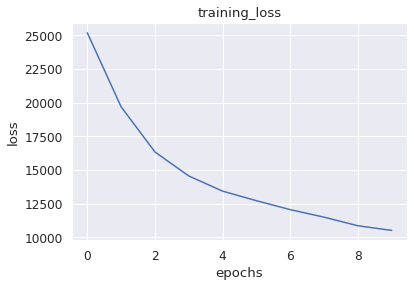

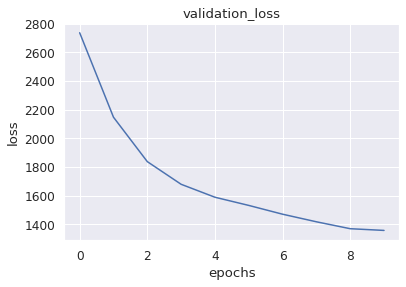

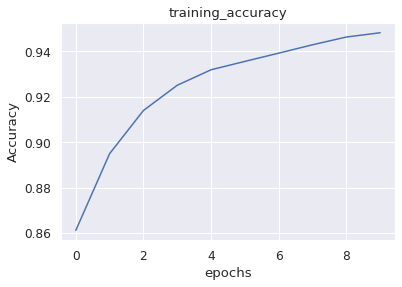

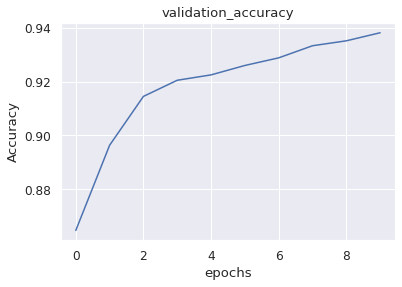

In [120]:
#three hidden layer with 30 nodes 
n1 = NeuralNetwork([784,30,30,30,10])
n = n1.fit(trainX, trainY, 10, 0.1)
titles = ['training_loss', 'validation_loss', 'training_accuracy', 'validation_accuracy']
for i,j in enumerate(titles):
  plt.plot(n[i])
  plt.title(lr)
  plt.xlabel('epochs')
  if i < 2:
    plt.ylabel('loss')
  else:
    plt.ylabel('Accuracy')
  plt.title(j)
  plt.show()

# **Part 2**

In this part, you will get hands-on experience in using tensorflow libraries to implement a CNN for the same mnist dataset used in part 1. It will also give you an idea which model performs better. For this part it is recommended to use Google Colab and GPU for faster training.

For this part, you will need to reshape both testX and trainX. We want the shape of trainX to be (60000,28,28,1) and the shape of testX to be (10000,28,28,1). Use np.reshape for this.

In [ ]:
trainX, trainY, testX, testY = load_dataset()
trainX =trainX.reshape(60000,28,28,1)
testX = testX.reshape(10000,28,28,1)

In [ ]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape)) #should print "Train: X=(60000,28,28,1), y=(60000,10)"
print('Test: X=%s, y=%s' % (testX.shape, testY.shape)) #should print "Test: X=(10000,28,28,1), y=(10000,10)"

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


In [ ]:
#Do not change this, it will be used in the end
labels={}
labels['0'] = 0
labels['1'] = 1
labels['2'] = 2
labels['3'] = 3
labels['4'] = 4
labels['5'] = 5
labels['6'] = 6
labels['7'] = 7
labels['8'] = 8
labels['9'] = 9

In [ ]:
#Hyperparameters, you can change them accordingly to get higher accuracy on test dataset
input_shape = (28,28,1)

# Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.
Model architecture:
*   See the image below for model architecture 
*   For convolutional layer, use kernel size as (3,3) and use relu as activation function
*   For Max Pooling layer, use pool size = (2,2)
*   Last Layer has softmax activation, the second last layer has relu activation
*   Total number of parameters should be 542,230







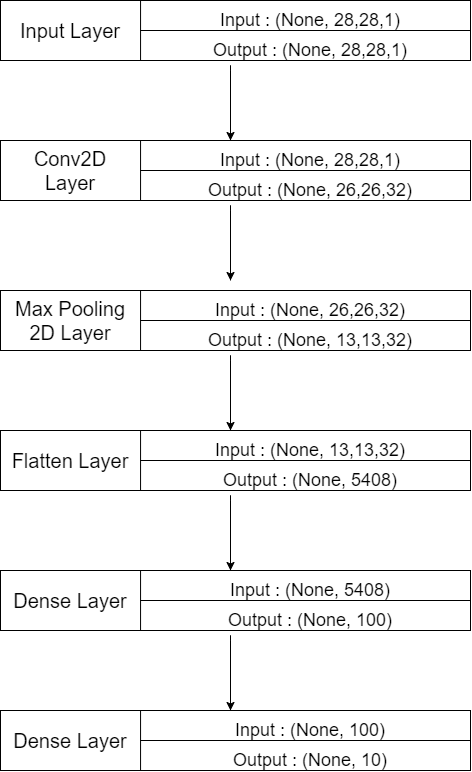

In [ ]:

def define_model():
  model = Sequential()
  model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  return model , model.summary()


In [ ]:
define_model()[1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


Compile model here by using optimizer = Adam, loss = categorical_crossentropy and metrics = accuracy. Use model.compile() for this. See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation. For seeing how to use optimizer, see [this](https://keras.io/api/optimizers/) link.

In [ ]:
model = define_model()[0]
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


Fit your model here. Use model.fit().  See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation to understand model.fit(). Pass in argument steps_per_epoch = floor(Total_train_images/batch_size) 

In [ ]:
loss_hist = model.fit(trainX,trainY,steps_per_epoch = 60000/100,epochs = 10)

Epoch 1/10
600/600 [==============================] - 23s 37ms/step - loss: 0.4345 - accuracy: 0.8780
Epoch 2/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0707 - accuracy: 0.9794
Epoch 3/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0467 - accuracy: 0.9862
Epoch 4/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0316 - accuracy: 0.9910
Epoch 5/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0245 - accuracy: 0.9924
Epoch 6/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0200 - accuracy: 0.9938
Epoch 7/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0146 - accuracy: 0.9955
Epoch 8/10
600/600 [==============================] - 23s 38ms/step - loss: 0.0117 - accuracy: 0.9964
Epoch 9/10
600/600 [==============================] - 23s 39ms/step - loss: 0.0076 - accuracy: 0.9977
Epoch 10/10
600/600 [==============================] - 23s 38ms/step - loss: 0.006

Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

Text(0, 0.5, 'loss')

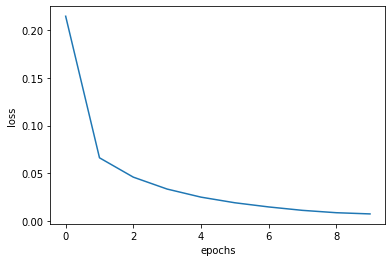

In [ ]:
plt.plot(loss_hist.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

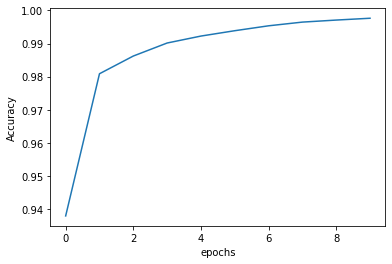

In [ ]:
plt.plot(loss_hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')

# Testing

Make predictions on Test Data. Use model.predict() for this

In [ ]:
y_pred = model.predict(testX)

Extract class label from the predictions. You may find np.argmax() useful for this

In [ ]:
yt_pred = []
for i in range(len(y_pred)):
    lbl = np.zeros(10)
    ind = np.argmax(y_pred[i])
    lbl[ind] = 1
    yt_pred.append(lbl)


Calculate and print accuracy on test data.

In [ ]:
print('Accuracy:',accuracy_score(np.argmax(testY, axis=1), np.argmax(yt_pred, axis=1))*100)

Accuracy: 98.53


Plot the confusion matrix here using the sklearn library. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [ ]:
conf_mat = confusion_matrix(np.argmax(testY, axis=1), np.argmax(yt_pred, axis=1))

In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.1)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10})
    plt.show()

Use the above function for plotting confusion matrix.

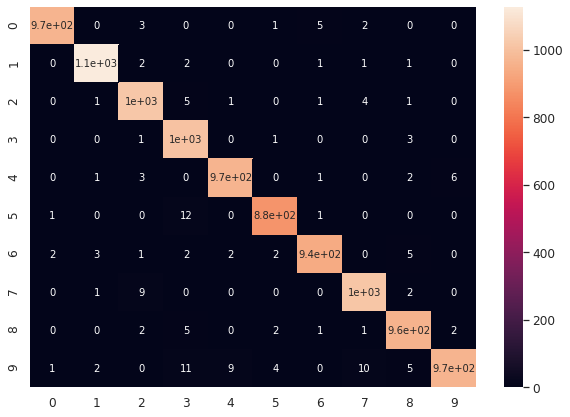

In [ ]:
plot_confusion_matrix(conf_mat)